In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from functools import partial
from collections import deque
%matplotlib inline
from scipy.integrate import solve_ivp
import sympy as sym
sym.init_printing()
import tensorflow as tf

In [13]:
g = 9.81 # gravitational acceleration
# Note: m = 1, l = 1, g = 9.81 for all pendulums

### Single Pendulum

In [11]:
# animation function

def animate_single_pendulum(xs, ys, frames = 400,filename='pend.mp4'):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
 

    axes.set_ylim(-2,2)
    axes.set_xlim(-2,2)


    line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
    line0, = axes.plot([0], [0], lw = 2, color = 'black', marker = 'o', markersize = 10)

    axes.legend([line0,line1], ['Pivot', 'Pendulum'])

    def init():
        line1.set_data([], [])
        return line1, 


    # animation function
    def animate(i):
        x0, y0 = xs[i], ys[i]
        # x, y values to be plotted
        line1.set_data(x0, y0)
        return line1,
    
    # calling the animation function    
    anim = animation.FuncAnimation(fig, animate,
                                init_func = init,
                                frames = frames,
                                interval = 20,
                                blit = True)
    anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)
    

In [15]:
class Small_Pendulum:
    def __init__(self, initial_theta=0, initial_omega=0, time = 10, dt = 0.01):

        # small pendulum equation: theta'' + g/l * theta = 0
        sol = solve_ivp(lambda t, y : [y[1], -g * y[0]], 
                        [0, time], 
                        [initial_theta, initial_omega], 
                        t_eval=np.arange(0, time, dt))
        
        self.thetas = sol.y[0]
        
        self.xs = np.sin(self.thetas) # x position
        self.ys = -np.cos(self.thetas) # y position


class Pendulum:
    def __init__(self, initial_theta=0, initial_omega=0, time = 10, dt = 0.01):

        # pendulum equation: theta'' + g/l * sin(theta) = 0
        sol = solve_ivp(lambda t, y : [y[1], -g * np.sin(y[0])], 
                        [0, time], 
                        [initial_theta, initial_omega], 
                        t_eval=np.arange(0, time, dt))

        self.thetas = sol.y[0]

        self.xs = np.sin(self.thetas) # x position
        self.ys = -np.cos(self.thetas) # y position

class Pendulum_with_drag:
    def __init__(self, initial_theta=0, initial_omega=0, time = 10, dt = 0.01, b = 0.1):

        # pendulum equation: theta'' + b * theta' + g/l * sin(theta) = 0
        sol = solve_ivp(lambda t, y : [y[1], -g * np.sin(y[0]) - b * y[1]], 
                        [0, time], 
                        [initial_theta, initial_omega], 
                        t_eval=np.arange(0, time, dt))

        self.thetas = sol.y[0]

        self.xs = np.sin(self.thetas) # x position
        self.ys = -np.cos(self.thetas) # y position

In [26]:
theta = np.pi - 1
perfect = Pendulum(initial_theta=theta)
small = Small_Pendulum(initial_theta=theta)
drag = Pendulum_with_drag(initial_theta = theta, b = 0.1)

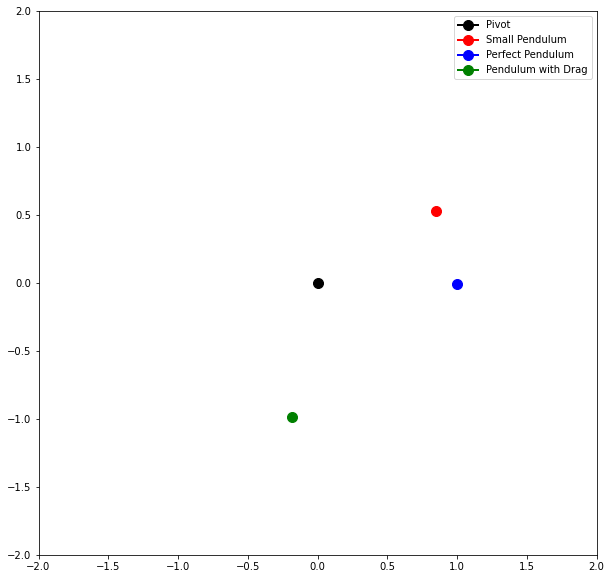

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
 

axes.set_ylim(-2,2)
axes.set_xlim(-2,2)

line0, = axes.plot([0], [0], lw = 2, color = 'black', marker = 'o', markersize = 10)
line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line2, = axes.plot([], [], lw = 2, color = 'blue', marker = 'o', markersize = 10)
line3, = axes.plot([], [], lw = 2, color = 'green', marker = 'o', markersize = 10)

axes.legend([line0, line1, line2, line3], ['Pivot', 'Small Pendulum', 'Perfect Pendulum', 'Pendulum with Drag'])

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3,


# animation function
def animate(i):
    x0, y0 = small.xs[i], small.ys[i]
    x1, y1 = perfect.xs[i], perfect.ys[i]
    x2, y2 = drag.xs[i], drag.ys[i]
    # x, y values to be plotted
    line1.set_data(x0, y0)
    line2.set_data(x1, y1)
    line3.set_data(x2, y2)
    return line1, line2, line3,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 800,
                            interval = 20,
                            blit = True)
anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)

### Adding Perturbations

In [ ]:
class Perturbable_Pendulum_v4:
    def __init__(self, initial_theta=0, initial_omega=0, max_time = 10, dt = 0.01, alphas = [0 for i in range(1000)], beta = 10000, damping = 0.1):
        
        # pendulum equation: theta'' + damping*theta' + g*sin(theta) = perturbation
        # perturbation is a function of time
        # we will use alpha_i * exp(-beta*(t-t_i)**2) as a pulse 
        # perturbation is a sum of pulses
        
        self.time = 0
        self.theta = initial_theta
        self.omega = initial_omega
        
        self.dt = dt
        self.max_time = max_time
        
        self.alphas = alphas # alphas is a list of constants that determine the height of the pulse
        self.beta = beta # beta is a constant that determines the width of the pulse
        self.damping = damping # damping is a constant that determines the damping of the pendulum
        
        # sol = self.solve_pulses()
        # self.thetas = sol.y[0]
        # self.xs = np.sin(self.thetas)
        # self.ys = -np.cos(self.thetas)
        
        
    def pulse(self, t, t_i, alpha):
        # the nth pulse formula
        # pulse is a bump function that happens in between time steps
        return alpha * np.exp(-self.beta * (t - t_i)**2)
    
    def pulse_sum(self, t):
        # the sum of all pulses
        return np.sum([self.pulse(t, t_i, alpha) for t_i, alpha in zip(np.arange(0, self.max_time, self.dt), self.alphas)])
    
    def state_space(self, t, y):
        # state space vector [theta, omega, t] -> d/dt -> [omega, -g/l * sin(theta) + -damping * omega + perturbation, 1]
        return [y[1], -g*np.sin(y[0]) + -self.damping*y[1] + self.pulse_sum(y[2]), 1]
    
    def solve_pulses(self):
        # solve the nth pulse
        return solve_ivp(self.state_space,
                    [0, self.max_time],
                    [self.theta, self.omega, 0], 
                    t_eval=np.arange(0, self.max_time, self.dt))
    
    def dynamic_state_space(self, t, y, alpha, t_i):
        # state space vector [theta, omega, t] -> d/dt -> [omega, -g/l * sin(theta) + local_perturbation, 1]
        return [y[1], -g*np.sin(y[0]) + -self.damping*y[1] + self.pulse(y[2], t_i, alpha), 1]
    
    def solve_time_step(self, initial_theta, initial_omega, initial_time, alpha):
        # solve the nth time step
        return solve_ivp(partial(self.dynamic_state_space, alpha=alpha, t_i=(initial_time + self.dt/2)),
                         [initial_time, initial_time + self.dt],
                         [initial_theta, initial_omega, initial_time])
    
    def dynamic_solve(self):
        # we will solve the pendulum in time steps
        # we will use the previous time step's solution as the initial condition for the next time step
        time = 0
        step = 0
        alphas = self.alphas
        theta = self.theta
        omega = self.omega
        thetas = [theta]
        omegas = [omega]
        times = [time]
        while time < self.max_time:
            sol = self.solve_time_step(theta, omega, time, alphas[step])
            theta = sol.y[0][-1]
            omega = sol.y[1][-1]
            time += self.dt
            step += 1
            thetas.append(theta)
            omegas.append(omega)
            times.append(time)
        return np.array(thetas), np.array(omegas), np.array(times)
    
    def dynamic_step(self, alpha):
        # we will solve the pendulum in time steps
        # we will use the previous time step's solution as the initial condition for the next time step
        self.time += self.dt
        sol = self.solve_time_step(self.theta, self.omega, self.time, alpha)
        self.theta = sol.y[0][-1]
        self.omega = sol.y[1][-1]
        return self.theta, self.omega, self.time
    
    def error(self, theta, omega, alpha):
        pos_theta = self.solve_time_step(theta, omega, 0, alpha).y[0][-1]
        neg_theta = self.solve_time_step(theta, omega, 0, -alpha).y[0][-1]
        
        if abs(np.cos(pos_theta) - 1) < abs(np.cos(neg_theta) - 1) and abs(np.cos(pos_theta) - 1) < abs(np.cos(theta) - 1):
            return 1
        elif abs(np.cos(neg_theta) - 1) < abs(np.cos(pos_theta) - 1) and abs(np.cos(neg_theta) - 1) < abs(np.cos(theta) - 1):
            return 0
        else:
            return 0.5
    
    def machined_solve(self, model, base_alpha):
        # we will solve the pendulum in time steps
        # we will use the previous time step's solution as the initial condition for the next time step
        time = 0
        theta = self.theta
        omega = self.omega
        thetas = [theta]
        omegas = [omega]
        times = [time]
        alphas = []
        def p_model(test, model=model, base_alpha=base_alpha):
            return (np.argmax(model.predict(test, verbose=False))*2 - 1) * base_alpha * -1
        
        while time < self.max_time:
            alpha = p_model(np.array([[theta, omega]]))
            sol = self.solve_time_step(theta, omega, time, alpha)
            theta = sol.y[0][-1]
            omega = sol.y[1][-1]
            time += self.dt
            thetas.append(theta)
            omegas.append(omega)
            times.append(time)
            alphas.append(alpha)
        return np.array(thetas), np.array(omegas), np.array(times), np.array(alphas)

In [ ]:
thetas = []
omegas = []
alphas = []
base_alpha = 100

p4 = Perturbable_Pendulum_v4(initial_theta = np.pi/2, initial_omega = -10, max_time = 100)
while p4.time < p4.max_time:
    theta, omega, time = p4.dynamic_step(0)
    thetas.append(theta)
    omegas.append(omega)
    alphas.append(p4.error(theta, omega, base_alpha))
    
p4 = Perturbable_Pendulum_v4(initial_theta = -np.pi-0.01, initial_omega = 13, max_time = 100)
while p4.time < p4.max_time:
    theta, omega, time = p4.dynamic_step(0)
    thetas.append(theta)
    omegas.append(omega)
    alphas.append(p4.error(theta, omega, base_alpha))

In [ ]:
# input layer with thetas and omegas
# output layer with alphas
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,)), # input layer, 2 neurons
    tf.keras.layers.Dense(10, activation=tf.nn.relu), # hidden layer, 10 neurons
    tf.keras.layers.Dropout(0.2), # dropout layer, 20% of neurons are randomly dropped
    tf.keras.layers.Dense(3) # output layer, 2 neurons
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
model.fit(np.array([thetas, omegas]).T, np.array(alphas), epochs=5)

Epoch 1/5
625/625 [==============================] - 1s 712us/step - loss: 7.4049 - accuracy: 0.3103
Epoch 2/5
625/625 [==============================] - 0s 696us/step - loss: 0.8168 - accuracy: 0.3817
Epoch 3/5
625/625 [==============================] - 0s 708us/step - loss: 0.6301 - accuracy: 0.3961
Epoch 4/5
625/625 [==============================] - 0s 708us/step - loss: 0.6077 - accuracy: 0.4030
Epoch 5/5
625/625 [==============================] - 0s 721us/step - loss: 0.5966 - accuracy: 0.4065


In [ ]:
p4 = Perturbable_Pendulum_v4(initial_theta = np.pi/2, initial_omega = -3, max_time = 10)

In [ ]:
thetas, omegas, times, alphas = p4.machined_solve(model, base_alpha)

In [ ]:
xs = np.sin(thetas)
ys = -np.cos(thetas)

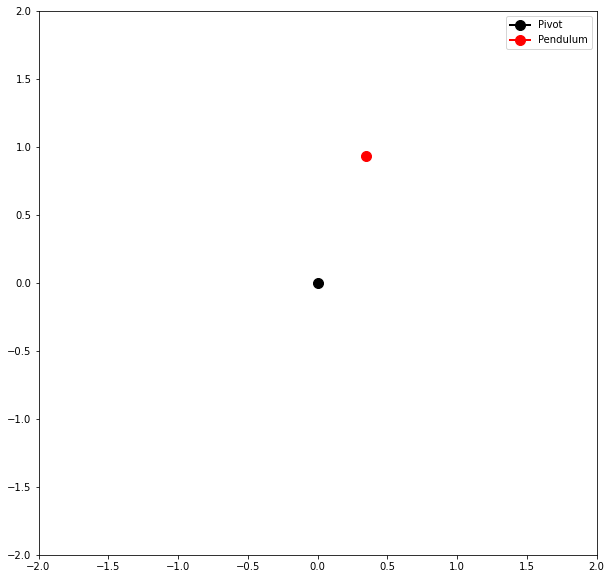

In [ ]:
animate_single_pendulum(xs, ys,frames=600, filename='pend.mp4')













### Double Pendulum

System Set-up

In [34]:
# we take m = 1, l = 1 for both pendulums for simplicity
g, t = sym.symbols('g t')

# thetas, omegas, and alphas are functions of time
theta1 = sym.Function('theta1')(t)
theta2 = sym.Function('theta2')(t)
dtheta1_dt = sym.diff(theta1, t)
dtheta2_dt = sym.diff(theta2, t)
ddtheta1_dtdt = sym.diff(dtheta1_dt, t)
ddtheta2_dtdt = sym.diff(dtheta2_dt, t)

# the equations of motion in Cartesian coordinates
x1 = sym.sin(theta1)
y1 = -sym.cos(theta1)
x2 = x1 + sym.sin(theta2)
y2 = y1 - sym.cos(theta2)

Lagrangian

$$ \mathcal{L} = T - U $$

In [35]:
# kinetic energy
T = sym.Rational(1,2) * (sym.diff(x1, t)**2 + sym.diff(y1, t)**2 + sym.diff(x2, t)**2 + sym.diff(y2, t)**2)
# potential energy
U = g * (y1 + y2)
# Lagrangian
L = (T - U).simplify()

Euler-Lagrange Equations

$$ \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{q_i}} - \frac{\partial \mathcal{L}}{\partial q_i} = 0 $$

In [36]:
del_L_t1 = sym.diff(L, theta1)
del_L_t2 = sym.diff(L, theta2)
d_del_L_dt1 = sym.diff(sym.diff(L, dtheta1_dt), t).simplify()
d_del_L_dt2 = sym.diff(sym.diff(L, dtheta2_dt), t).simplify()

L_1 = sym.Eq(del_L_t1, d_del_L_dt1)
L_2 = sym.Eq(del_L_t2, d_del_L_dt2)

Solve in terms of angular acceleration

In [37]:
sol = sym.solve([L_1, L_2], [ddtheta1_dtdt, ddtheta2_dtdt])
ddtheta1_dtdt = sol[ddtheta1_dtdt]
ddtheta2_dtdt = sol[ddtheta2_dtdt]

Put in form of a system of first order ODEs:
$$ \underline{\dot{z}} = f(t,\underline{z})$$

$$ \underline{z} = [\theta_1, \dot{\theta}_1,\theta_2, \dot{\theta}_2] \implies \underline{\dot{z}} = [\dot{\theta}_1, \ddot{\theta}_1,\dot{\theta}_2, \ddot{\theta}_2]$$

In [38]:
# Turn the symbolic equations into functions
func_dtheta1_dt = sym.lambdify(dtheta1_dt, dtheta1_dt)
func_ddtheta1_dtdt = sym.lambdify((theta1, theta2, dtheta1_dt, dtheta2_dt, g), ddtheta1_dtdt)
func_dtheta2_dt = sym.lambdify(dtheta2_dt, dtheta2_dt)
func_ddtheta2_dtdt = sym.lambdify((theta1, theta2, dtheta1_dt, dtheta2_dt, g), ddtheta2_dtdt)

# Define the state vector
def dbl_pendulum_state(t, th, g=9.81):
    th1, dth1, th2, dth2 = th
    return np.array([dth1, func_ddtheta1_dtdt(th1, th2, dth1, dth2, g), dth2,  func_ddtheta2_dtdt(th1, th2, dth1, dth2, g)])

In [39]:
# Solve the ODE: Initial condition vector is [theta1, dtheta1, theta2, dtheta2]
double_pendulum = solve_ivp(dbl_pendulum_state, 
                            [0, 30], 
                            [np.pi+0.3,  2, np.pi+0.2, -1], 
                            t_eval=np.arange(0, 30, 0.01))

# Get the x and y positions of the pendulums
th1 = double_pendulum.y[0]
dth1 = double_pendulum.y[1]
th2 = double_pendulum.y[2]
dth2 = double_pendulum.y[3]
x1 = np.sin(th1)
y1 = -np.cos(th1)
x2 = x1 + np.sin(th2)
y2 = y1 - np.cos(th2)

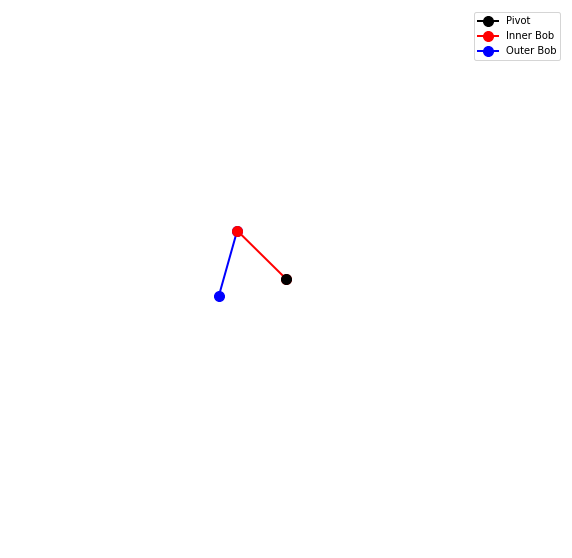

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
axes.set_ylim(-4,4)
axes.set_xlim(-4,4)

line2, = axes.plot([], [], lw = 2, color = 'blue', marker = 'o', markersize = 10)
line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line0, = axes.plot([0], [0], lw = 2, color = 'black', marker = 'o', markersize = 10)

axes.legend([line0, line1, line2], ['Pivot','Inner Bob', 'Outer Bob'])
axes.set_axis_off()
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,


# animation function
def animate(i):
    # x, y values to be plotted
    line1.set_data([0,x1[i]], [0,y1[i]])
    line2.set_data([x1[i], x2[i]], [y1[i], y2[i]])
        
    return line1, line2,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 1500,
                            interval = 20,
                            blit = True)
anim.save('dblpend.mp4', writer = 'ffmpeg', fps = 30)